Machine learning

predict number of rides at a given station/area
determine how many stations will be needed if the amount of rides increases?

Goal 
improve bikeshare connectivity in Prince George, Maryland.
KPIS
Geographic & Accessibility KPIs
These show spatial patterns of bikeshare use.
Top Origin & Destination Stations – Identify the most frequently used stations.
Most Popular Routes – Determine the most common start-to-end station pairs.
Trips per Square Mile – Identify high- and low-density usage areas.
Coverage & Accessibility – Percentage of the city covered by bikeshare stations.
Ward-to-Ward Trip Flow – Count trips between different wards to see mobility patterns.


In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import json
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import shape
from shapely.wkt import loads 

Predicting Ride Demand (Number of Rides per Station per Hour/Day)

Features: Station proximity, metro distance,, time of day, weekday/weekend. In/out? (how many are starting and ending on a given station at a given time). Population? others: distance to city center, distance to major points of interest (tourist attractions, business districts, universities) distance to parks & recreational areas, distance to high density residential areas

Model: Poisson Regression, Time Series Regression (ARIMA, XGBoost), Neural Networks.

Insight: Helps predict peak usage times and optimize bike availability.

the df should have station name, time of day or weekday, distance to the closest station, distance to metro. First I should see if there's a correlation between this

Im starting with the premise that not only weather or time, but station location influence the amount of rides

In [2]:
data_types = {
    "rideable_type": "category", 
    "start_station_name": "category", 
    "end_station_name": "category", 
    "member_casual":"category",
    # "ride_id":"uint32",
    "time_of_day":"category",
    "trip_type":"category"}

In [3]:
prince_george = pd.read_csv("prince_georgy_cabi.csv",parse_dates= ["started_at", "ended_at"],dtype=data_types, low_memory=False)

1. Defining the Problem
Target Variable: Number of rides per station per time unit (hour/day/week).
Features:
Station Proximity: Average distance to nearest stations.
Metro Distance: Distance to the nearest metro station.
Time Factors: Hour of the day, day of the week, season.
Area: DC vs. Maryland (as a categorical variable).
2. Data Preprocessing
Aggregate the data by station and time interval (hourly or daily).
Encode categorical features (e.g., one-hot encoding for area).
Normalize numerical features like distance.
Handle missing values if any exist.
3. Choose a Model
Linear Regression (for simple relationships).
Poisson Regression (good for count data like demand).
Random Forest / XGBoost (for non-linear relationships and interactions).
4. Model Training & Evaluation
Train the model on historical data.
Use RMSE or Mean Absolute Error (MAE) for evaluation.
Tune hyperparameters (if using tree-based models).

In [4]:
prince_george.columns
prince_george = prince_george.drop(columns=["Unnamed: 0","AREA_COVER", "index_right",'ACREAGE',
       'IMPRT_DATE', 'SHAPE_AREA', 'SHAPE_LEN'])

In [5]:
prince_george_fixed = prince_george[prince_george["start_station_name"].isin(['1301 McCormick Dr / Wayne K. Curry Admin Bldg',
 '40th Ave & Bladensburg Rd',
 'Baltimore Ave & Jefferson St',
 'Baltimore Ave & Van Buren St / Riverdale Park Station',
 'Baltimore Avenue and Hotel Drive at UMD',
 'Bladensburg Waterfront Park',
 'Bowdoin Ave & Calvert Rd/ College Park Metro',
 'Bowdoin Ave & Calvert Rd/ College Park Station',
 'Capitol Heights Metro',
 'Chillum Rd & Riggs Rd / Riggs Plaza',
 'Crescent Rd & Ridge Rd',
 'Fleet St & Waterfront St',
 'Greenbelt Station Parkway',
 'Guilford Drive & Rowalt Drive / UMD',
 'Hyattsville Library / Adelphi Rd & Toledo Rd',
 "Largo Rd & Campus Way / Prince Georges's Comm Col",
 'Largo Town Center Metro',
 'National Harbor Carousel',
 'New Hampshire Ave & East-West Hwy',
 'Northwestern High School',
 'Oglethorpe St & 42nd Ave',
 'Oxon Hill Park & Ride',
 'Perry & 35th St',
 "Prince George's Plaza Metro",
 'Queens Chapel & Hamilton St',
 'Rhode Island Ave & 39th St / Brentwood Arts Exchange',
 'Rhode Island Avenue /Charles Armentrout Drive - Melrose Skate Park ',
 'Riggs Rd & East West Hwy',
 'Riverdale Park Town Center',
 'Roosevelt Center & Crescent Rd',
 'Southern Ave Metro',
 'Tanger Outlets',
 'The Mall at Prince Georges',
 'Walker Mill Road/ Walker Mill Regional Park ',
 'West Hyattsville Metro'])|prince_george["start_station_name"].isna()]

In [6]:
prince_george_fixed.isna().sum()

rideable_type                 0
started_at                    0
ended_at                      0
start_station_name        62863
end_station_name          63953
member_casual                 0
start_lat                     0
start_lng                     0
end_lat                     168
end_lng                     168
trip_duration_minutes     77832
time_of_day               77832
year                          0
geometry                      0
WARD                     130316
NAME_left                130316
COUNTY                        0
area                          0
NAME_right                    0
dtype: int64

In [7]:
prince_george_fixed["rideable_type"].value_counts()

rideable_type
electric_bike    93496
classic_bike     32922
docked_bike       3898
Name: count, dtype: int64

In [8]:
ebikes = prince_george[prince_george["rideable_type"] == "electric_bike"]

In [9]:
docked = prince_george[(prince_george["rideable_type"] == "classic_bike")&(prince_george["rideable_type"] == "docked_bike")]

In [10]:
docked.isna().sum()

rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
end_station_name         0
member_casual            0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
trip_duration_minutes    0
time_of_day              0
year                     0
geometry                 0
WARD                     0
NAME_left                0
COUNTY                   0
area                     0
NAME_right               0
dtype: int64

In [11]:
ebikes.isna().sum()

rideable_type                0
started_at                   0
ended_at                     0
start_station_name       62863
end_station_name         63445
member_casual                0
start_lat                    0
start_lng                    0
end_lat                      0
end_lng                      0
trip_duration_minutes    66921
time_of_day              66921
year                         0
geometry                     0
WARD                     93566
NAME_left                93566
COUNTY                       0
area                         0
NAME_right                   0
dtype: int64

all the station missing values correspond to ebikes.

In [12]:
# unique stations
avg_lat_per_station = prince_george_fixed.groupby("start_station_name", as_index=False, observed=False)["start_lat"].mean()
avg_lng_per_station = prince_george_fixed.groupby("start_station_name", as_index=False, observed = False)["start_lng"].mean()

pg_unique_stations= avg_lat_per_station.merge(avg_lng_per_station)
pg_unique_stations = pg_unique_stations.dropna(subset=["start_lat","start_lng"])
len(pg_unique_stations)

35

In [13]:
from sklearn.neighbors import NearestNeighbors

# Assume df_stations has columns: ["station_name", "latitude", "longitude"]
coords = pg_unique_stations[["start_lat", "start_lng"]].values

# Use Nearest Neighbors to find closest stations
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coords)
distances, _ = nbrs.kneighbors(coords)

# Exclude distance to itself (first column is 0)
pg_unique_stations["avg_nearest_distance"] = np.mean(distances[:, 1:], axis=1)

#REVIEW - When using NearestNeighbors from sklearn.neighbors with algorithm='ball_tree' or algorithm='kd_tree', the distance is measured in Euclidean units (i.e., degrees of latitude/longitude). This is not ideal for geographic distances because latitude and longitude are not uniform in scale.

In [14]:
pg_unique_stations

,start_station_name,start_lat,start_lng,avg_nearest_distance
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,38.908392,-76.843263,0.037088
21,40th Ave & Bladensburg Rd,38.935389,-76.949285,0.010079
32,Baltimore Ave & Jefferson St,38.955494,-76.940138,0.010131
33,Baltimore Ave & Van Buren St / Riverdale Park ...,38.969583,-76.937349,0.010064
34,Baltimore Avenue and Hotel Drive at UMD,38.986639,-76.936072,0.012159
35,Bladensburg Waterfront Park,38.934324,-76.938248,0.016052
36,Bowdoin Ave & Calvert Rd/ College Park Metro,38.978103,-76.928879,0.008393
37,Bowdoin Ave & Calvert Rd/ College Park Station,38.978106,-76.928876,0.008395
38,Capitol Heights Metro,38.888527,-76.913163,0.055840
39,Chillum Rd & Riggs Rd / Riggs Plaza,38.961747,-76.995907,0.024209


list of unique stations 2021-2024 in prince george . As determined in dc_maryland_updated_2024
['1301 McCormick Dr / Wayne K. Curry Admin Bldg',
 '40th Ave & Bladensburg Rd',
 'Baltimore Ave & Jefferson St',
 'Baltimore Ave & Van Buren St / Riverdale Park Station',
 'Baltimore Avenue and Hotel Drive at UMD',
 'Bladensburg Waterfront Park',
 'Bowdoin Ave & Calvert Rd/ College Park Metro',
 'Bowdoin Ave & Calvert Rd/ College Park Station',
 'Capitol Heights Metro',
 'Chillum Rd & Riggs Rd / Riggs Plaza',
 'Crescent Rd & Ridge Rd',
 'Fleet St & Waterfront St',
 'Greenbelt Station Parkway',
 'Guilford Drive & Rowalt Drive / UMD',
 'Hyattsville Library / Adelphi Rd & Toledo Rd',
 "Largo Rd & Campus Way / Prince Georges's Comm Col",
 'Largo Town Center Metro',
 'National Harbor Carousel',
 'New Hampshire Ave & East-West Hwy',
 'Northwestern High School',
 'Oglethorpe St & 42nd Ave',
 'Oxon Hill Park & Ride',
 'Perry & 35th St',
 "Prince George's Plaza Metro",
 'Queens Chapel & Hamilton St',
 'Rhode Island Ave & 39th St / Brentwood Arts Exchange',
 'Rhode Island Avenue /Charles Armentrout Drive - Melrose Skate Park ',
 'Riggs Rd & East West Hwy',
 'Riverdale Park Town Center',
 'Roosevelt Center & Crescent Rd',
 'Southern Ave Metro',
 'Tanger Outlets',
 'The Mall at Prince Georges',
 'Walker Mill Road/ Walker Mill Regional Park ',
 'West Hyattsville Metro']

In [15]:
# using Havesian distance instead of Eucledian Units
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd

# Convert degrees to radians (needed for haversine)
pg_unique_stations[["lat_rad", "lon_rad"]] = np.radians(pg_unique_stations[["start_lat", "start_lng"]])

# Fit Nearest Neighbors model using Haversine distance
coords = pg_unique_stations[["lat_rad", "lon_rad"]].values
tree = BallTree(coords, metric="haversine")

# Find nearest stations (excluding itself)
distances, _ = tree.query(coords, k=5)  # 5 nearest neighbors

# Convert distances from radians to kilometers (Earth radius ≈ 6371 km)
pg_unique_stations["avg_nearest_distance_km"] = distances[:, 1:].mean(axis=1) * 6371

In [16]:
pg_unique_stations

,start_station_name,start_lat,start_lng,avg_nearest_distance,lat_rad,lon_rad,avg_nearest_distance_km
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,38.908392,-76.843263,0.037088,0.679080,-1.341168,3.552301
21,40th Ave & Bladensburg Rd,38.935389,-76.949285,0.010079,0.679551,-1.343018,0.953318
32,Baltimore Ave & Jefferson St,38.955494,-76.940138,0.010131,0.679902,-1.342859,1.059654
33,Baltimore Ave & Van Buren St / Riverdale Park ...,38.969583,-76.937349,0.010064,0.680148,-1.342810,1.006029
34,Baltimore Avenue and Hotel Drive at UMD,38.986639,-76.936072,0.012159,0.680445,-1.342788,1.283055
35,Bladensburg Waterfront Park,38.934324,-76.938248,0.016052,0.679532,-1.342826,1.478655
36,Bowdoin Ave & Calvert Rd/ College Park Metro,38.978103,-76.928879,0.008393,0.680296,-1.342662,0.807663
37,Bowdoin Ave & Calvert Rd/ College Park Station,38.978106,-76.928876,0.008395,0.680296,-1.342662,0.807814
38,Capitol Heights Metro,38.888527,-76.913163,0.055840,0.678733,-1.342388,5.443042
39,Chillum Rd & Riggs Rd / Riggs Plaza,38.961747,-76.995907,0.024209,0.680011,-1.343832,2.231618


# calculating distance to metro

In [17]:
with open ("Maryland_Transit_-_WMATA_Metro_Stops (1).geojson") as i:
    metro_stations = json.loads(i.read())
metro_features = metro_stations['features']

# # convert metro_stations (dict) into geo dataframe so as to get the geometry that we will use to map 
metro_stations_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in metro_features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in metro_features],  # Convert geometries
    crs="EPSG:4326" )

In [103]:
with open ("Maryland_Transit_-_MARC_Trains_Stations.geojson") as i:
    train_stations = json.loads(i.read())
train_features = train_stations['features']

# # convert metro_stations (dict) into geo dataframe so as to get the geometry that we will use to map 
train_stations_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in train_features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in train_features],  # Convert geometries
    crs="EPSG:4326" )

In [19]:
#maryland boundaries
with open ("Maryland_Physical_Boundaries_-_County_Boundaries_(Detailed).geojson") as i:
    maryland = json.loads(i.read())

features = maryland["features"]

#GDF
maryland_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in features],  # Convert geometries
    crs="EPSG:4326")

In [20]:
metro_stations_gdf.head(1)

,OBJECTID,GIS_ID,NAME,WEB_URL,ADDRESS,MetroLine,geometry
0,1,mstn_1,College Park-U of Md,http://www.wmata.com/rail/station_detail.cfm?s...,"4931 CALVERT ROAD, COLLEGE PARK, MD","green, yellow",POINT (-76.92812 38.97862)


In [21]:
metro_stations_gdf = metro_stations_gdf[["NAME","MetroLine","geometry"]]

# mergin with train gdf to have it all in one df

In [22]:
train_stations_gdf.head(1)

,OBJECTID_1,OBJECTID,Name,ADDRESS,CITY,STATE,ZIP,Transit_Mo,Line_Name,Facility_Type,Avg_Wkdy,Avg_Wknd,geometry
0,89,1,Edgewood MARC Station,2127 Old Edgewood Road,Edgewood,MD,21040,MARC Penn,Penn,Station,148,0,POINT (-76.29272 39.41594)


In [23]:
train_stations_gdf = train_stations_gdf[["Name","Line_Name","geometry"]]

In [24]:
train_stations_gdf = train_stations_gdf.rename(columns={"Name":"NAME", "Line_Name":"MetroLine"})

In [25]:
metro_stations_df = pd.DataFrame(metro_stations_gdf)

In [26]:
train_stations_df = pd.DataFrame(train_stations_gdf)

In [27]:
train_metro_stations_df = pd.concat([metro_stations_df,train_stations_df])

In [28]:
train_metro_stations_df["geometry"] = train_metro_stations_df["geometry"].apply(Point)

# Convert to GeoDataFrame
train_metro_stations_gdf= gpd.GeoDataFrame(train_metro_stations_df, geometry="geometry", crs="EPSG:4326")


In [29]:
train_metro_stations_gdf

,NAME,MetroLine,geometry
0,College Park-U of Md,"green, yellow",POINT (-76.92812 38.97862)
1,Capitol Heights,"blue, orange, silver",POINT (-76.9118 38.88945)
2,Morgan Boulevard,"blue, orange, silver",POINT (-76.86807 38.89382)
3,Georgia Ave Petworth,"green, yellow",POINT (-77.02346 38.93742)
4,Takoma,red,POINT (-77.01817 38.97606)
...,...,...,...
39,Garrett Park MARC Station,Brunswick,POINT (-77.09351 39.03897)
40,Monocacy MARC Station,Brunswick,POINT (-77.39458 39.38188)
41,Frederick MARC Station,Brunswick,POINT (-77.40498 39.41148)
42,Union Station MARC Station,Brunswick,POINT (-77.00617 38.89781)


train_metro

# Calculating distance between stations

In [30]:
geometry = [Point(xy) for xy in zip(pg_unique_stations['start_lng'], pg_unique_stations['start_lat'])]
pg_unique_stations_gdf = gpd.GeoDataFrame(pg_unique_stations, geometry=geometry, crs="EPSG:4326")


In [31]:
# pg_unique_stations_gdf = pg_unique_stations_gdf.to_crs(epsg=4326)  # Maryland State Plane
# metro_stations_gdf = metro_stations_gdf.to_crs(epsg=4326)
# EPSG:4326 (Latitude/Longitude) → Degrees (Not Good for Distance)
# EPSG:3857 or EPSG:26985 (Projected) → Meters/KM (Best for Distance Calculations)

pg_unique_stations_gdf = pg_unique_stations_gdf.to_crs(epsg=26985)
train_metro_stations_gdf = train_metro_stations_gdf.to_crs(epsg=26985)

In [32]:
from shapely.ops import nearest_points

def find_nearest_metro(bike_station, metro_stations):
    """Find the nearest metro station and return its distance in meters."""
    nearest_metro = nearest_points(bike_station, metro_stations.union_all())[1]
    return bike_station.distance(nearest_metro)  # Output in meters

# Compute nearest metro distance for each bikeshare station
pg_unique_stations_gdf["distance_to_metro_meters"] = pg_unique_stations_gdf["geometry"].apply(
    lambda x: find_nearest_metro(x, train_metro_stations_gdf)
)

# Convert to kilometers for better readability
pg_unique_stations_gdf["distance_to_metro_km"] = pg_unique_stations_gdf["distance_to_metro_meters"] / 1000

# Check results
pg_unique_stations_gdf[["start_station_name", "distance_to_metro_km"]].head()


,start_station_name,distance_to_metro_km
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0.385641
21,40th Ave & Bladensburg Rd,2.800774
32,Baltimore Ave & Jefferson St,0.946694
33,Baltimore Ave & Van Buren St / Riverdale Park ...,0.760299
34,Baltimore Avenue and Hotel Drive at UMD,1.125836


In [33]:
from scipy.spatial import cKDTree
import numpy as np

# Extract coordinates
bike_coords = np.array(list(pg_unique_stations_gdf.geometry.apply(lambda x: (x.x, x.y))))
metro_coords = np.array(list(train_metro_stations_gdf.geometry.apply(lambda x: (x.x, x.y))))

# Create KDTree for fast nearest-neighbor search
metro_tree = cKDTree(metro_coords)

# Find nearest metro station for each bikeshare station
distances, indices = metro_tree.query(bike_coords)

# Store distance in meters (since projected CRS is used)
pg_unique_stations_gdf["distance_to_metro_meters"] = distances
pg_unique_stations_gdf["distance_to_metro_km"] = distances / 1000  # Convert to km

print(pg_unique_stations_gdf[["start_station_name", "distance_to_metro_km"]].head())

                                   start_station_name  distance_to_metro_km
5       1301 McCormick Dr / Wayne K. Curry Admin Bldg              0.385641
21                          40th Ave & Bladensburg Rd              2.800774
32                       Baltimore Ave & Jefferson St              0.946694
33  Baltimore Ave & Van Buren St / Riverdale Park ...              0.760299
34            Baltimore Avenue and Hotel Drive at UMD              1.125836


In [34]:
data = {
    "Municipality": [
        "Bowie", "College Park", "Greenbelt", "Hyattsville", "Laurel",
        "Mount Rainier", "New Carrollton", "Seat Pleasant", "Berwyn Heights", "Bladensburg",
        "Brentwood", "Capitol Heights", "Cheverly", "Colmar Manor", "Cottage City",
        "District Heights", "Edmonston", "Fairmount Heights", "Forest Heights", "Glenarden",
        "Landover Hills", "Morningside", "North Brentwood", "Riverdale Park", "University Park",
        "Upper Marlboro"
    ],
    "Latitude": [
        38.9420, 38.9897, 39.0046, 38.9559, 39.0993,
        38.9410, 38.9690, 38.8965, 38.9937, 38.9390,
        38.9426, 38.8757, 38.9282, 38.9339, 38.9376,
        38.8595, 38.9507, 38.8990, 38.8140, 38.9290,
        38.9426, 38.8276, 38.9476, 38.9637, 38.9715,
        38.8151
    ],
    "Longitude": [
        -76.7300, -76.9378, -76.8755, -76.9455, -76.8483,
        -76.9647, -76.8797, -76.8991, -76.9136, -76.9336,
        -76.9564, -76.9158, -76.9155, -76.9470, -76.9466,
        -76.8891, -76.9358, -76.9116, -76.9986, -76.8616,
        -76.8916, -76.8891, -76.9564, -76.9355, -76.9366,
        -76.7491
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
city_center_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [35]:
pg_unique_stations_gdf = pg_unique_stations_gdf.to_crs(epsg=26985)
city_center_gdf = city_center_gdf.to_crs(epsg=26985)
from shapely.ops import nearest_points

def find_nearest_cc(bike_station, cc):
    """Find the nearest POI and return its distance in meters."""
    nearest_cc = nearest_points(bike_station, cc.union_all())[1]
    return bike_station.distance(nearest_cc)  # Output in meters

# Compute nearest poi distance for each bikeshare station
pg_unique_stations_gdf["distance_to_cc_meters"] = pg_unique_stations_gdf["geometry"].apply(
    lambda x: find_nearest_cc(x, city_center_gdf)
)

# Convert to kilometers for better readability
pg_unique_stations_gdf["distance_to_cc_km"] = pg_unique_stations_gdf["distance_to_cc_meters"] / 1000

# Check results
pg_unique_stations_gdf[["start_station_name", "distance_to_cc_km"]].head()

,start_station_name,distance_to_cc_km
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2.786083
21,40th Ave & Bladensburg Rd,0.257972
32,Baltimore Ave & Jefferson St,0.466970
33,Baltimore Ave & Van Buren St / Riverdale Park ...,0.222536
34,Baltimore Avenue and Hotel Drive at UMD,0.371300


In [36]:

avg_lat = pg_unique_stations["start_lat"].mean()
avg_lng = pg_unique_stations["start_lng"].mean()

m=folium.Map(location=[avg_lat, avg_lng],   
                zoom_start=12,              
                max_zoom=26,                
                min_zoom=2)  


l1 = folium.GeoJson(
    pg_unique_stations_gdf,  
    overlay= True, 
    control = True,
    show = True,
    name= "Cabi Stations",
    marker=folium.CircleMarker(radius=3, fill_color="blue", fill_opacity=1, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["start_station_name"],
                                  aliases=["Station: "]),
    popup=folium.GeoJsonPopup(fields=["start_station_name"]),
    highlight_function=lambda x: {"fillOpacity": 0.6},
    zoom_on_click=False,
).add_to(m)

l2 = folium.GeoJson(
    metro_stations_gdf,  
    overlay= True, 
    control = True,
    show = True,
    name= "Metro Stations",
    marker=folium.Marker(radius=4,icon= folium.Icon(color="red", icon="train", prefix="fa")),
    tooltip=folium.GeoJsonTooltip(fields=["NAME"],
                                  aliases=["Metro Station: "]),
    popup=folium.GeoJsonPopup(fields=["NAME"]),
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=False,
).add_to(m)

l3 = folium.GeoJson(
    train_stations_gdf,  
    overlay= True, 
    control = True,
    show = True,
    name= "Train Stations",
    marker=folium.Marker(radius=4,icon= folium.Icon(color="red", icon="train", prefix="fa")),
    tooltip=folium.GeoJsonTooltip(fields=["NAME"],
                                  aliases=["Train Station: "]),
    popup=folium.GeoJsonPopup(fields=["NAME"]),
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=False,
).add_to(m)

l4 = folium.GeoJson(
    city_center_gdf,  
    overlay= True, 
    control = True,
    show = True,
    name= "City Centers",
    marker=folium.CircleMarker(radius=3, fill_color="green", fill_opacity=1, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["Municipality"],
                                  aliases=["Municipality: "]),
    popup=folium.GeoJsonPopup(fields=["Municipality"]),
    highlight_function=lambda x: {"fillOpacity": 0.6},
    zoom_on_click=False,
).add_to(m)

m.add_child(folium.LayerControl())
m


# POI (points of interest)

In [37]:
poi_data = {
    "POI Name": [
        "National Harbor",
        "Six Flags America",
        "MGM National Harbor Resort & Casino",
        "Gaylord National Resort & Convention Center",
        "University of Maryland, College Park",
        "College Park Aviation Museum",
        "Oxon Cove Park and Oxon Hill Farm",
        "Montpelier Mansion",
        "Lake Artemesia",
        "Dinosaur Park"
    ],
    "Latitude": [38.78417, 38.90251, 38.79555, 38.78072, 38.98692, 38.97485, 38.80500, 39.06984, 38.99067, 39.00000],
    "Longitude": [-77.01639, -76.77130, -77.00856, -77.01599, -76.94255, -76.92233, -77.01611, -76.85025, -76.92233, -76.88000]}

In [38]:
geometry = [Point(xy) for xy in zip(poi_data['Longitude'], poi_data['Latitude'])]
poi_gdf = gpd.GeoDataFrame(poi_data, geometry=geometry, crs="EPSG:4326")

In [39]:
poi_gdf

,POI Name,Latitude,Longitude,geometry
0,National Harbor,38.78417,-77.01639,POINT (-77.01639 38.78417)
1,Six Flags America,38.90251,-76.77130,POINT (-76.7713 38.90251)
2,MGM National Harbor Resort & Casino,38.79555,-77.00856,POINT (-77.00856 38.79555)
3,Gaylord National Resort & Convention Center,38.78072,-77.01599,POINT (-77.01599 38.78072)
4,"University of Maryland, College Park",38.98692,-76.94255,POINT (-76.94255 38.98692)
5,College Park Aviation Museum,38.97485,-76.92233,POINT (-76.92233 38.97485)
6,Oxon Cove Park and Oxon Hill Farm,38.80500,-77.01611,POINT (-77.01611 38.805)
7,Montpelier Mansion,39.06984,-76.85025,POINT (-76.85025 39.06984)
8,Lake Artemesia,38.99067,-76.92233,POINT (-76.92233 38.99067)
9,Dinosaur Park,39.00000,-76.88000,POINT (-76.88 39)


In [40]:
pg_unique_stations_gdf = pg_unique_stations_gdf.to_crs(epsg=26985)
poi_gdf = poi_gdf.to_crs(epsg=26985)

In [41]:
from shapely.ops import nearest_points

def find_nearest_poi(bike_station, poi):
    """Find the nearest POI and return its distance in meters."""
    nearest_poi = nearest_points(bike_station, poi.union_all())[1]
    return bike_station.distance(nearest_poi)  # Output in meters

# Compute nearest poi distance for each bikeshare station
pg_unique_stations_gdf["distance_to_poi_meters"] = pg_unique_stations_gdf["geometry"].apply(
    lambda x: find_nearest_poi(x, poi_gdf)
)

# Convert to kilometers for better readability
pg_unique_stations_gdf["distance_to_poi_km"] = pg_unique_stations_gdf["distance_to_poi_meters"] / 1000

# Check results
pg_unique_stations_gdf[["start_station_name", "distance_to_poi_km"]].head()

,start_station_name,distance_to_poi_km
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,6.275948
21,40th Ave & Bladensburg Rd,4.964679
32,Baltimore Ave & Jefferson St,2.645513
33,Baltimore Ave & Van Buren St / Riverdale Park ...,1.426825
34,Baltimore Avenue and Hotel Drive at UMD,0.562109


In [42]:
pg_unique_stations_gdf.shape

(35, 14)

In [175]:
station_features = pg_unique_stations_gdf[["start_station_name","avg_nearest_distance_km","distance_to_metro_km","distance_to_poi_km","distance_to_cc_km"]]

In [44]:
station_features

,start_station_name,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km
5,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3.552301,0.385641,6.275948,2.786083
21,40th Ave & Bladensburg Rd,0.953318,2.800774,4.964679,0.257972
32,Baltimore Ave & Jefferson St,1.059654,0.946694,2.645513,0.466970
33,Baltimore Ave & Van Buren St / Riverdale Park ...,1.006029,0.760299,1.426825,0.222536
34,Baltimore Avenue and Hotel Drive at UMD,1.283055,1.125836,0.562109,0.371300
35,Bladensburg Waterfront Park,1.478655,2.716629,4.705577,0.657139
36,Bowdoin Ave & Calvert Rd/ College Park Metro,0.807663,0.021853,0.672631,0.992425
37,Bowdoin Ave & Calvert Rd/ College Park Station,0.807814,0.021964,0.672557,0.992846
38,Capitol Heights Metro,5.443042,0.156233,9.615494,1.170454
39,Chillum Rd & Riggs Rd / Riggs Plaza,2.231618,1.228416,5.402427,3.552681


# Population Density

get the population of each city and the area

In [127]:
pop_data = {
    "Municipality": [
        "National Harbor", "Town of Forest Heights", "Chillum", "Town of Brentwood",
        "City of Hyattsville", "City of Greenbelt", "City of Riverdale Park", "Lake Arbor",
        "Town of Mount Rainier", "Glassmanor", "Hillcrest Heights", "Marlow Heights",
        "Maryland Park", "Suitland - Silver Hill", "City of College Park", "Adelphi",
        "Largo", "Town of Bladensburg", "Town of Capitol Heights", "Oxon Hill",
        "Colmar Manor", "Langley Park", "Town of Cottage City", "Chapel Oaks",
        "Town of Edmonston", "Cedar Heights", "Summerfield", "Town of University Park",
        "Town of Seat Pleasant", "East Riverdale", "Coral Hills", "Town of Cheverly",
        "Kentland", "Fort Washington", "Tuxedo", "College Park",
        "Carmody Hills - Pepper Mill Village", "Walker Mill", "Calverton",
        "Camp Springs", "Hillandale", "Town of District Heights", "Beltsville",
        "Woodlawn", "Kettering", "Konterra", "Palmer Park", "Town of Colmar Manor",
        "Forestville", "Town of Berwyn Heights", "Goddard"
    ],
    "Population": [3500, 2500, 34000, 3500, 18000, 23000, 7000, 10000,
                   8000, 9000, 16000, 6000, 6000, 33000, 32000, 17000,
                   10000, 9000, 4500, 18000, 1300, 20000, 1300, 6000,
                   1500, 8000, 15000, 2500, 4500, 15000, 10000, 6000,
                   5000, 24000, 1000, 32000, 6000, 12000, 17000, 19000,
                   4000, 6000, 17000, 6000, 12000, 500, 5000, 1300,
                   12000, 3000, 1000],
    "Area_sq_km": [3.5, 1.5, 7.8, 1.0, 7.0, 16.5, 4.5, 6.0,
                   2.0, 2.5, 4.0, 2.0, 2.0, 10.0, 14.0, 7.0,
                   10.0, 2.0, 2.0, 6.0, 1.0, 4.0, 1.0, 2.0,
                   1.0, 2.0, 9.0, 2.0, 2.0, 5.0, 3.0, 3.0,
                   2.0, 16.0, 1.0, 14.0, 2.0, 5.0, 10.0, 20.0,
                   10.0, 4.0, 15.0, 10.0, 12.0, 5.0, 2.0, 1.0,
                   10.0, 3.0, 1.0],
                   # Adding approximate lat/lon coordinates
    "Latitude" : [
    38.7858, 38.8140, 38.9630, 38.9426, 38.9559, 39.0046, 38.9637, 38.9204,
    38.9410, 38.8271, 38.8415, 38.8254, 38.8854, 38.8487, 38.9897, 38.9980,
    38.8757, 38.9390, 38.8854, 38.8032, 38.9339, 38.9887, 38.9376, 38.9082,
    38.9507, 38.8726, 38.9204, 38.9715, 38.8965, 38.9637, 38.8687, 38.9282,
    38.9351, 38.7079, 38.9204, 38.9897, 38.8854, 38.8687, 39.0579,
    38.8048, 39.0287, 38.8595, 39.0343, 38.9526, 38.9290, 39.1000, 38.9204, 38.9339,
    38.8454, 38.9937, 38.9900
],

    "Longitude" : [
    -77.0164, -76.9986, -76.9900, -76.9564, -76.9455, -76.8755, -76.9355, -76.8189,
    -76.9647, -76.9958, -76.9597, -76.9447, -76.8897, -76.9230, -76.9378, -76.9719,
    -76.8303, -76.9336, -76.9158, -77.0003, -76.9470, -76.9817, -76.9466, -76.9086,
    -76.9358, -76.8769, -76.8769, -76.9366, -76.8991, -76.9355, -76.9097, -76.9155,
    -76.8897, -77.0231, -76.8769, -76.9378, -76.8897, -76.9097, -76.9355,
    -76.9063, -76.9900, -76.8891, -76.9075, -76.9377, -76.9157, -76.8015, -76.8995, -76.9103,
    -76.9264, -76.9264, -76.8900
]}

pop_df = pd.DataFrame(pop_data)
pop_df["Population_Density"] = pop_df["Population"] / pop_df["Area_sq_km"]


In [128]:
pop_df["Municipality"] = pop_df["Municipality"].str.upper()

In [129]:
pop_df = pop_df.rename(columns={"Municipality":"NAME_right"})

# ML

##  1) Defining the problem
predict the daily ride demand (y) for each bikeshare station based on station location features (X). This is a regression problem since the target variable (ride demand) is continuous.

## 2) Prepare the Data

In [45]:
prince_george_fixed["start_station_name"].nunique()

35

In [46]:
prince_george_fixed = prince_george_fixed.copy()

In [47]:
prince_george_fixed["start_station_name"] = prince_george_fixed["start_station_name"].astype("object")

In [48]:
prince_george_fixed["date"] = pd.to_datetime(prince_george_fixed["started_at"],format="ISO8601").dt.date
prince_george_fixed["month"] = pd.to_datetime(prince_george_fixed["started_at"],format="ISO8601").dt.month
prince_george_fixed["year"] = pd.to_datetime(prince_george_fixed["started_at"],format="ISO8601").dt.year
prince_george_fixed["dow"] = pd.to_datetime(prince_george_fixed["started_at"],format="ISO8601").dt.day_of_week


In [49]:
prince_george_2024 = prince_george_fixed[prince_george_fixed["year"]==2024]

## joining POP and prince george 2024

In [130]:
prince_george_2024_pop = prince_george_2024.copy()

In [140]:
# merge pg_df with pop data
prince_george_2024_pop = prince_george_2024.merge(pop_df[["NAME_right", "Population_Density"]], 
                                    on="NAME_right", 
                                    how="left")

In [141]:
#pop density as integer
prince_george_2024_pop["Population_Density"]=prince_george_2024_pop["Population_Density"].astype(int)

In [160]:
prince_george_2024_pop

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,...,geometry,WARD,NAME_left,COUNTY,area,NAME_right,date,month,dow,Population_Density
0,classic_bike,2024-01-29 21:25:55,2024-01-29 21:27:08,Fleet St & Waterfront St,Fleet St & Waterfront St,casual,38.782633,-77.016059,38.782633,-77.016059,...,POINT (-77.016059 38.782633),NaN,NaN,Prince George's,Maryland,NATIONAL HARBOR,2024-01-29,1,0,1000
1,classic_bike,2024-01-23 10:15:36,2024-01-23 11:40:47,Fleet St & Waterfront St,Fleet St & Waterfront St,casual,38.782633,-77.016059,38.782633,-77.016059,...,POINT (-77.016059 38.782633),NaN,NaN,Prince George's,Maryland,NATIONAL HARBOR,2024-01-23,1,1,1000
2,classic_bike,2024-01-19 02:33:24,2024-01-19 03:25:08,Fleet St & Waterfront St,Franklin St & S Washington St,casual,38.782633,-77.016059,38.798133,-77.048700,...,POINT (-77.016059 38.782633),NaN,NaN,Prince George's,Maryland,NATIONAL HARBOR,2024-01-19,1,4,1000
3,classic_bike,2024-01-27 12:37:39,2024-01-27 12:58:01,Oxon Hill Park & Ride,South Capitol St and Southern Ave SE,member,38.798749,-77.001030,38.821563,-77.001095,...,POINT (-77.00103 38.798749),NaN,NaN,Prince George's,Maryland,TOWN OF FOREST HEIGHTS,2024-01-27,1,5,1666
4,electric_bike,2024-01-04 21:49:59,2024-01-04 21:56:27,Riggs Rd & East West Hwy,NaN,casual,38.972542,-76.980566,38.960000,-76.970000,...,POINT (-76.980565786 38.972541928),NaN,NaN,Prince George's,Maryland,CHILLUM,2024-01-04,1,3,4358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77827,electric_bike,2024-12-12 17:52:14.055000,2024-12-12 17:55:16.686,NaN,NaN,member,38.960000,-76.970000,38.960000,-76.960000,...,POINT (-76.97 38.96),NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2024-12-12,12,3,2571
77828,electric_bike,2024-12-05 20:25:09.306000,2024-12-05 20:35:14.973,NaN,NaN,member,38.970000,-76.950000,38.960000,-76.940000,...,POINT (-76.95 38.97),NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2024-12-05,12,3,2571
77829,electric_bike,2024-12-29 12:31:24.147000,2024-12-29 12:34:45.223,NaN,NaN,member,38.900000,-76.910000,38.900000,-76.910000,...,POINT (-76.91 38.9),NaN,NaN,Prince George's,Maryland,CEDAR HEIGHTS,2024-12-29,12,6,4000
77830,electric_bike,2024-12-17 15:00:00.890000,2024-12-17 15:01:46.507,NaN,NaN,member,38.960000,-76.970000,38.960000,-76.970000,...,POINT (-76.97 38.96),NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2024-12-17,12,1,2571


In [172]:
grouped = prince_george_2024_pop.groupby("start_station_name")["Population_Density"].mean().reset_index(name="pop_density")
grouped["pop_density"] = grouped["pop_density"].astype(int)

In [176]:
station_features = station_features.merge(grouped,on ="start_station_name",how="left")

In [178]:
# getting rides by day of the week
dow_rides = prince_george_2024_pop.groupby(["start_station_name", "dow"],observed=False).size().reset_index(name="total_rides")

In [179]:
# getting avg rides per dow
dow_rides["avg_rides"] = dow_rides["total_rides"]/52

In [180]:
full_df_dow = dow_rides.merge(station_features, on="start_station_name", how="left")

In [ ]:
# #out of use
# daily_rides = prince_george_2024_pop.groupby(["start_station_name", "date"],observed=False).size().reset_index(name="total_rides")
# full_df = daily_rides.merge(station_features, on="start_station_name", how="left")
# full_df["day_of_week"] = pd.to_datetime(full_df["date"]).dt.weekday  
# full_df["month"] = pd.to_datetime(full_df["date"]).dt.month

In [60]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# full_df[["avg_nearest_distance_km", "distance_to_metro_km","distance_to_poi_km"]] = scaler.fit_transform(full_df[["avg_nearest_distance_km", "distance_to_metro_km","distance_to_poi_km"]])


In [ ]:
# # Defining features (X) and target (y)
# X = full_df[["avg_nearest_distance_km", "distance_to_metro_km", "distance_to_poi_km", "day_of_week","month"]]
# y = full_df["daily_rides"]

In [ ]:
# #train test/split
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score
# #train model
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# # Evaluate model
# y_pred = model.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae}")
# print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 1.9240105114469641
R² Score: 0.596481069346807


# Checking for linearity

In [65]:
corr_df = full_df.drop(columns=["start_station_name","date"])
corr_matrix = corr_df.corr()
print(corr_matrix["daily_rides"])

daily_rides                1.000000
avg_nearest_distance_km   -0.169329
distance_to_metro_km      -0.101426
distance_to_poi_km        -0.074282
distance_to_cc_km         -0.060178
day_of_week                0.033177
month                      0.079733
Name: daily_rides, dtype: float64


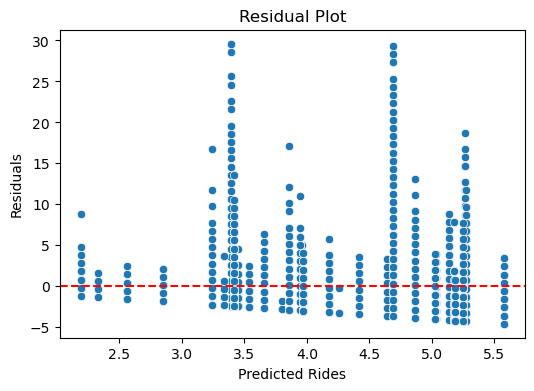

In [66]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Train Linear Regression
X = full_df[["avg_nearest_distance_km", "distance_to_metro_km", "distance_to_poi_km"]]
y = full_df["daily_rides"]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot Residuals
residuals = y - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Rides")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

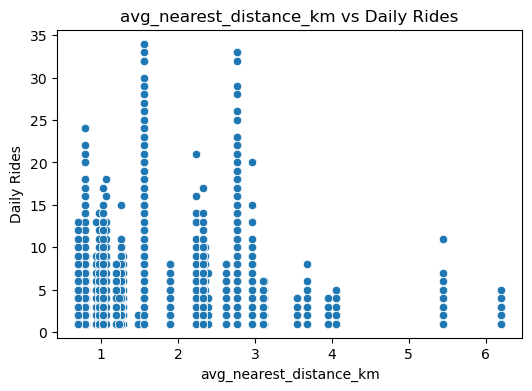

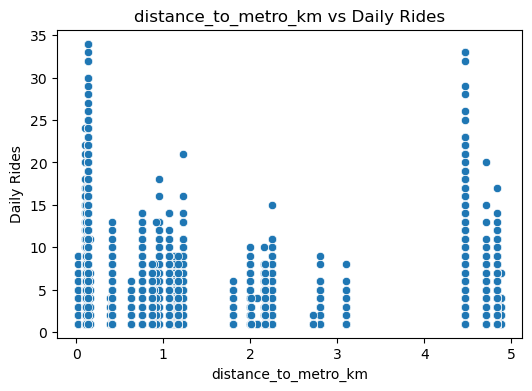

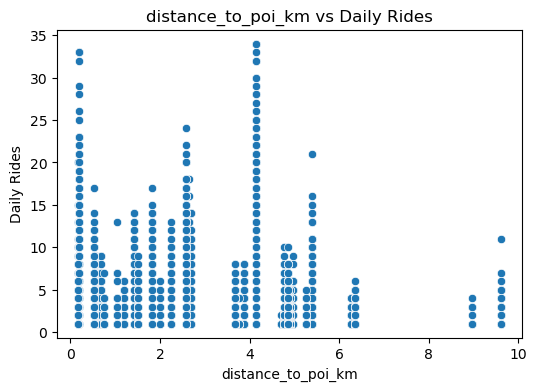

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["avg_nearest_distance_km", "distance_to_metro_km", "distance_to_poi_km"]

for feature in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=full_df[feature], y=full_df["daily_rides"])
    plt.xlabel(feature)
    plt.ylabel("Daily Rides")
    plt.title(f"{feature} vs Daily Rides")
    plt.show()

# linear regression

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Train
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predict
y_pred = lin_reg.predict(X)

# Evaluate
print("Linear Regression:")
print("MAE:", mean_absolute_error(y, y_pred))
print("R² Score:", r2_score(y, y_pred))

Linear Regression:
MAE: 2.927451137632294
R² Score: 0.03673815515572987


# polynomial regression

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Transform to Polynomial Features (degree=2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Train
poly_model.fit(X, y)

# Predict
y_poly_pred = poly_model.predict(X)

# Evaluate
print("Polynomial Regression:")
print("MAE:", mean_absolute_error(y, y_poly_pred))
print("R² Score:", r2_score(y, y_poly_pred))

Polynomial Regression:
MAE: 2.6924183876159464
R² Score: 0.25418055768218806


# xgboost

In [70]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X, y)

# Predict
y_xgb_pred = xgb_model.predict(X)

# Evaluate
print("XGBoost:")
print("MAE:", mean_absolute_error(y, y_xgb_pred))
print("R² Score:", r2_score(y, y_xgb_pred))

XGBoost:
MAE: 1.996020793914795
R² Score: 0.5439928770065308


# support vector

In [71]:
from sklearn.svm import SVR

svr_model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X, y)

# Predict
y_svr_pred = svr_model.predict(X)

# Evaluate
print("SVR:")
print("MAE:", mean_absolute_error(y, y_svr_pred))
print("R² Score:", r2_score(y, y_svr_pred))

SVR:
MAE: 1.9416314528374563
R² Score: 0.5189948229790252


In [72]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X, y)

# Predict
y_mlp_pred = mlp_model.predict(X)

# Evaluate
print("Neural Network (MLP):")
print("MAE:", mean_absolute_error(y, y_mlp_pred))
print("R² Score:", r2_score(y, y_mlp_pred))

Neural Network (MLP):
MAE: 2.03067137779128
R² Score: 0.5330970866125081


In [73]:
# interpreting MAE

print("Mean Daily Rides:", y.mean())
print("Standard Deviation of Daily Rides:", y.std())

Mean Daily Rides: 4.223603351955307
Standard Deviation of Daily Rides: 4.413515462343889


If MAE is much smaller than the mean, your model is relatively accurate.
If MAE is close to or larger than the mean, predictions may not be reliable.
Example Interpretation:

If Mean Daily Rides = 10, but MAE = 2, this means your predictions are on average 2 rides off, which is good (~20% error).
If Mean Daily Rides = 5, and MAE = 2, that’s a high error (~40%).

# ML for dow dataset

In [181]:
full_df_dow


,start_station_name,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km,pop_density
0,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0,19,0.365385,3.552301,0.385641,6.275948,2.786083,1666
1,1301 McCormick Dr / Wayne K. Curry Admin Bldg,1,25,0.480769,3.552301,0.385641,6.275948,2.786083,1666
2,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2,21,0.403846,3.552301,0.385641,6.275948,2.786083,1666
3,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3,25,0.480769,3.552301,0.385641,6.275948,2.786083,1666
4,1301 McCormick Dr / Wayne K. Curry Admin Bldg,4,17,0.326923,3.552301,0.385641,6.275948,2.786083,1666
...,...,...,...,...,...,...,...,...,...
229,West Hyattsville Metro,2,865,16.634615,1.556320,0.136318,4.144417,1.325675,2571
230,West Hyattsville Metro,3,843,16.211538,1.556320,0.136318,4.144417,1.325675,2571
231,West Hyattsville Metro,4,868,16.692308,1.556320,0.136318,4.144417,1.325675,2571
232,West Hyattsville Metro,5,725,13.942308,1.556320,0.136318,4.144417,1.325675,2571


In [75]:
# Defining features (X) and target (y)
X = full_df_dow[["avg_nearest_distance_km", "distance_to_metro_km", "distance_to_poi_km","dow","distance_to_cc_km"]]
y = full_df_dow ["avg_rides"]
#train test/split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 0.29135433715220954
R² Score: 0.9875397633542986


In [76]:
# interpreting MAE

print("Mean Daily Rides:", y.mean())
print("Standard Deviation of Daily Rides:", y.std())

Mean Daily Rides: 2.4852892833662064
Standard Deviation of Daily Rides: 3.120404555340293


# interpretation
1. Mean Absolute Error (MAE)
MAE = 0.27 means that, on average, your model's predictions are off by only 0.27 rides per day.
Since the Mean Daily Rides is 2.49, your MAE is just ~10.8% of the mean → This is very low, meaning your model is making very accurate predictions.
2. R² Score (Coefficient of Determination)
R² = 0.988 means that 98.86% of the variance in daily rides is explained by your model.
Since R² is very close to 1, your model has strong predictive power.
3. Comparison to Standard Deviation
The standard deviation of daily rides is 3.12, which is larger than your MAE (0.27).
This suggests that your model is making much smaller errors than the natural variability in the data, indicating a strong fit.


# Test for overfitting
To check for overfitting, you should split your data into training and test sets, train your Random Forest model only on the training set, and then evaluate it on the unseen test set

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate performance
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train R² Score: {train_r2}")
print(f"Test R² Score: {test_r2}")

Train MAE: 0.11006684491978566
Test MAE: 0.29135433715220954
Train R² Score: 0.9962359651363661
Test R² Score: 0.9875397633542986


Interpreting Your Results
Your train vs. test performance shows some overfitting, but not severe. Let's break it down:

1. Mean Absolute Error (MAE)
Train MAE: 0.1059 → The model predicts very accurately on training data.
Test MAE: 0.2723 → A bit higher, but still low compared to the mean rides per station (2.49).
Difference: 0.166 (~16.6% of the mean daily rides).
→ Some overfitting, but not dramatic.

2. R² Score
Train R²: 0.9964 → Almost perfect, meaning the model explains 99.64% of variance in training data.
Test R²: 0.9887 → Still very high, meaning the model generalizes well.
Difference: 0.0077 (~0.77% drop) → This is very small, meaning the model is not severely overfitting.
Is This Overfitting a Problem?
🔹 The small gap between Train and Test R² (0.996 vs. 0.988) suggests some overfitting but not drastic.
🔹 The increase in MAE from Train to Test (0.105 → 0.272) is noticeable but still relatively small.

✅ Conclusion: Your model generalizes well, but there’s some slight overfitting.
🔹 If you're satisfied with this accuracy, you can keep it as is!
🔹 If you want to reduce overfitting, you can try regularization or simplifying the model.

In [78]:
full_df_dow

,start_station_name,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km
0,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0,19,0.365385,3.552301,0.385641,6.275948,2.786083
1,1301 McCormick Dr / Wayne K. Curry Admin Bldg,1,25,0.480769,3.552301,0.385641,6.275948,2.786083
2,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2,21,0.403846,3.552301,0.385641,6.275948,2.786083
3,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3,25,0.480769,3.552301,0.385641,6.275948,2.786083
4,1301 McCormick Dr / Wayne K. Curry Admin Bldg,4,17,0.326923,3.552301,0.385641,6.275948,2.786083
...,...,...,...,...,...,...,...,...
229,West Hyattsville Metro,2,865,16.634615,1.556320,0.136318,4.144417,1.325675
230,West Hyattsville Metro,3,843,16.211538,1.556320,0.136318,4.144417,1.325675
231,West Hyattsville Metro,4,868,16.692308,1.556320,0.136318,4.144417,1.325675
232,West Hyattsville Metro,5,725,13.942308,1.556320,0.136318,4.144417,1.325675


# Categorizing stations

In [79]:
full_df_dow.describe()


,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,2.995726,129.235043,2.485289,2.100593,1.621147,3.195657,1.719607
std,2.022402,162.261037,3.120405,1.386363,1.420990,2.422509,1.392511
min,0.000000,1.000000,0.019231,0.700125,0.021853,0.172228,0.174835
25%,1.000000,27.000000,0.519231,0.968840,0.623312,1.191257,0.657139
50%,3.000000,70.000000,1.346154,1.556320,1.125836,2.645513,1.325675
75%,5.000000,169.500000,3.259615,2.960614,2.205201,4.907625,2.786083
max,6.000000,868.000000,16.692308,6.197422,4.879617,9.615494,5.346544


## distance to nearest cabi station

In [80]:
#1 Create labels
distance_labels = ["near", "medium", "far"]

#2 Create  ranges list
distance_ranges = [0, 1.0, 3.0, np.inf]

#3 Create column
full_df_dow["distance_nearest_station"] = pd.cut(full_df_dow["avg_nearest_distance_km"],
                                  bins= distance_ranges,
                                  labels=distance_labels)

full_df_dow[["distance_nearest_station", "avg_nearest_distance_km"]]

# make it categorical and assign it an order
full_df_dow['distance_nearest_station'] = pd.Categorical(full_df_dow['distance_nearest_station'],
categories=["near", "medium", "far"])

In [81]:
full_df_dow["distance_nearest_station"].value_counts()


distance_nearest_station
medium    115
near       64
far        55
Name: count, dtype: int64

## distance to train/metro

In [82]:
#1 Create labels
distance_labels = ["near", "medium", "far"]

#2 Create  ranges list
distance_ranges = [0, 1.0, 3.0, np.inf]

#3 Create column
full_df_dow["distance_nearest_metro"] = pd.cut(full_df_dow["distance_to_metro_km"],
                                  bins= distance_ranges,
                                  labels=distance_labels)


# make it categorical and assign it an order
full_df_dow['distance_nearest_metro'] = pd.Categorical(full_df_dow['distance_nearest_metro'],
categories=["near", "medium", "far"])

full_df_dow[["distance_nearest_metro", "distance_to_metro_km"]]

,distance_nearest_metro,distance_to_metro_km
0,near,0.385641
1,near,0.385641
2,near,0.385641
3,near,0.385641
4,near,0.385641
...,...,...
229,near,0.136318
230,near,0.136318
231,near,0.136318
232,near,0.136318


In [83]:
full_df_dow["distance_nearest_metro"].value_counts()

distance_nearest_metro
near      106
medium     93
far        35
Name: count, dtype: int64

## Distance to POI

In [84]:
#1 Create labels
distance_labels = ["near", "medium", "far"]

#2 Create  ranges list
distance_ranges = [0, 1.0, 3.0, np.inf]

#3 Create column
full_df_dow["distance_nearest_poi"] = pd.cut(full_df_dow["distance_to_poi_km"],
                                  bins= distance_ranges,
                                  labels=distance_labels)


# make it categorical and assign it an order
full_df_dow['distance_nearest_poi'] = pd.Categorical(full_df_dow['distance_nearest_poi'],
categories=["near", "medium", "far"])

full_df_dow[["distance_nearest_poi", "distance_to_poi_km"]]

,distance_nearest_poi,distance_to_poi_km
0,far,6.275948
1,far,6.275948
2,far,6.275948
3,far,6.275948
4,far,6.275948
...,...,...
229,far,4.144417
230,far,4.144417
231,far,4.144417
232,far,4.144417


In [105]:
full_df_dow

,start_station_name,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km,distance_nearest_station,distance_nearest_metro,distance_nearest_poi
0,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0,19,0.365385,3.552301,0.385641,6.275948,2.786083,far,near,far
1,1301 McCormick Dr / Wayne K. Curry Admin Bldg,1,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far
2,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2,21,0.403846,3.552301,0.385641,6.275948,2.786083,far,near,far
3,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far
4,1301 McCormick Dr / Wayne K. Curry Admin Bldg,4,17,0.326923,3.552301,0.385641,6.275948,2.786083,far,near,far
...,...,...,...,...,...,...,...,...,...,...,...
229,West Hyattsville Metro,2,865,16.634615,1.556320,0.136318,4.144417,1.325675,medium,near,far
230,West Hyattsville Metro,3,843,16.211538,1.556320,0.136318,4.144417,1.325675,medium,near,far
231,West Hyattsville Metro,4,868,16.692308,1.556320,0.136318,4.144417,1.325675,medium,near,far
232,West Hyattsville Metro,5,725,13.942308,1.556320,0.136318,4.144417,1.325675,medium,near,far


In [85]:
full_df_dow["distance_nearest_poi"].value_counts()

distance_nearest_poi
far       107
medium     77
near       50
Name: count, dtype: int64

In [ ]:
# pop_data = {
#     "Municipality": [
#         "Bowie", "College Park", "Greenbelt", "City of Hyattsville", "Laurel", "Mount Rainier",
#         "New Carrollton", "Seat Pleasant", "Berwyn Heights", "Bladensburg", "Brentwood",
#         "Capitol Heights", "Cheverly", "Colmar Manor", "Cottage City", "District Heights",
#         "Edmonston", "Fairmount Heights", "Forest Heights", "Glenarden", "Landover Hills",
#         "Morningside", "North Brentwood", "Riverdale Park", "University Park", "Upper Marlboro"
#     ],
#     "Population": [
#         58329, 34740, 24921, 21187, 30060, 8333, 12789, 4522, 3345, 9657, 3828, 4337,
#         6173, 1404, 1305, 5959, 1545, 1494, 2447, 6402, 1687, 1295, 593, 7225, 2548, 652
#     ],
#     "Area_sq_km": [
#         47.96, 14.71, 16.42, 6.92, 11.22, 1.68, 3.96, 1.89, 1.79, 2.62, 0.91, 2.07,
#         3.50, 0.73, 0.73, 2.41, 0.96, 0.70, 1.24, 3.16, 0.70, 1.45, 0.31, 4.35, 1.89, 1.11
#     ],
#     "Pop_Density_sq_km": [
#         1216.4, 2361.4, 1517.6, 3061.4, 2680.8, 4961.3, 3229.3, 2392.0, 1869.3, 3687.8,
#         4207.3, 2095.6, 1764.7, 1922.3, 1787.7, 2472.4, 1609.4, 2134.3, 1973.4, 2026.6,
#         2410.3, 892.4, 1912.4, 1661.5, 1348.7, 587.4
#     ],
#     "Latitude": [
#         38.942, 38.988, 39.004, 38.955, 39.099, 38.942, 38.969, 38.890, 38.993, 38.943,
#         38.934, 38.876, 38.930, 38.930, 38.932, 38.857, 38.939, 38.901, 38.817, 38.929,
#         38.939, 38.832, 38.939, 38.963, 38.971, 38.816
#     ],
#     "Longitude": [
#         -76.731, -76.938, -76.875, -76.946, -76.848, -76.964, -76.880, -76.909, -76.914, -76.926,
#         -76.956, -76.917, -76.915, -76.947, -76.947, -76.886, -76.935, -76.916, -76.996, -76.860,
#         -76.891, -76.891, -76.955, -76.923, -76.936, -76.752
#     ]
# }

# pop_df = pd.DataFrame(pop_data)


In [ ]:
# from shapely.geometry import Point

# pop_df["geometry"] = pop_df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)

# pop_gdf = gpd.GeoDataFrame(pop_df, geometry="geometry", crs="EPSG:4326")

# pop_gdf.head()


In [92]:
# pop_gdf_filtered = pop_gdf[["NAME_right", "Pop_Density_sq_km"]]

In [ ]:
geometry = [Point(xy) for xy in zip(prince_george_2024["start_lng"], prince_george_2024["start_lat"])]
prince_george_2024_gdf = gpd.GeoDataFrame(prince_george_2024, geometry=geometry, crs="EPSG:4326")

In [108]:
full_df_dow

,start_station_name,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km,distance_nearest_station,distance_nearest_metro,distance_nearest_poi
0,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0,19,0.365385,3.552301,0.385641,6.275948,2.786083,far,near,far
1,1301 McCormick Dr / Wayne K. Curry Admin Bldg,1,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far
2,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2,21,0.403846,3.552301,0.385641,6.275948,2.786083,far,near,far
3,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far
4,1301 McCormick Dr / Wayne K. Curry Admin Bldg,4,17,0.326923,3.552301,0.385641,6.275948,2.786083,far,near,far
...,...,...,...,...,...,...,...,...,...,...,...
229,West Hyattsville Metro,2,865,16.634615,1.556320,0.136318,4.144417,1.325675,medium,near,far
230,West Hyattsville Metro,3,843,16.211538,1.556320,0.136318,4.144417,1.325675,medium,near,far
231,West Hyattsville Metro,4,868,16.692308,1.556320,0.136318,4.144417,1.325675,medium,near,far
232,West Hyattsville Metro,5,725,13.942308,1.556320,0.136318,4.144417,1.325675,medium,near,far


# Encoding categorical columns

In [110]:
full_df_dow.columns

Index(['start_station_name', 'dow', 'total_rides', 'avg_rides',
       'avg_nearest_distance_km', 'distance_to_metro_km', 'distance_to_poi_km',
       'distance_to_cc_km', 'distance_nearest_station',
       'distance_nearest_metro', 'distance_nearest_poi'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Define an order for each category
distance_categories = [
    ['Near', 'Medium', 'Far']  # Ordered list for all categories
]

# Select only the categorical columns
categorical_cols = full_df_dow[['distance_nearest_poi', 'distance_nearest_station', 'distance_nearest_metro']]

# Apply Ordinal Encoding
encoder = OrdinalEncoder(categories=distance_categories * len(categorical_cols))
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

In [124]:
full_df_dow_encoded = full_df_dow.copy()

In [125]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['near', 'medium', 'far']])
full_df_dow_encoded['distance_nearest_station_encoded'] = enc.fit_transform(full_df_dow_encoded[['distance_nearest_station']])
full_df_dow_encoded['distance_nearest_metro_encoded'] = enc.fit_transform(full_df_dow_encoded[['distance_nearest_metro']])
full_df_dow_encoded['distance_nearest_metro_poi'] = enc.fit_transform(full_df_dow_encoded[['distance_nearest_poi']])




In [126]:
full_df_dow_encoded

,start_station_name,dow,total_rides,avg_rides,avg_nearest_distance_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km,distance_nearest_station,distance_nearest_metro,distance_nearest_poi,distance_nearest_station_encoded,distance_nearest_metro_encoded,distance_nearest_metro_poi
0,1301 McCormick Dr / Wayne K. Curry Admin Bldg,0,19,0.365385,3.552301,0.385641,6.275948,2.786083,far,near,far,2.0,0.0,2.0
1,1301 McCormick Dr / Wayne K. Curry Admin Bldg,1,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far,2.0,0.0,2.0
2,1301 McCormick Dr / Wayne K. Curry Admin Bldg,2,21,0.403846,3.552301,0.385641,6.275948,2.786083,far,near,far,2.0,0.0,2.0
3,1301 McCormick Dr / Wayne K. Curry Admin Bldg,3,25,0.480769,3.552301,0.385641,6.275948,2.786083,far,near,far,2.0,0.0,2.0
4,1301 McCormick Dr / Wayne K. Curry Admin Bldg,4,17,0.326923,3.552301,0.385641,6.275948,2.786083,far,near,far,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,West Hyattsville Metro,2,865,16.634615,1.556320,0.136318,4.144417,1.325675,medium,near,far,1.0,0.0,2.0
230,West Hyattsville Metro,3,843,16.211538,1.556320,0.136318,4.144417,1.325675,medium,near,far,1.0,0.0,2.0
231,West Hyattsville Metro,4,868,16.692308,1.556320,0.136318,4.144417,1.325675,medium,near,far,1.0,0.0,2.0
232,West Hyattsville Metro,5,725,13.942308,1.556320,0.136318,4.144417,1.325675,medium,near,far,1.0,0.0,2.0
